# Protest Classification Using LLM

## Objectives
In this notebook, the objective is to use a Language Model (LLM) to classify each protest event in an ACLED dataset into predefined categories. Given this dataset which contains a ```note``` attribute providing detailed description about each protest event, leverage an LLM and example human labeled protest event to classify all protest evemts in the data so that we end up with dataset which will now have a ```predicted_category``` label. 
## Dataset
In this task, we are using the same ACLED data being used for the rest of the conflict analysis. Howver, in addition, we are using an annotated dataset which provides classification of each protest event in the ACLED dataset. In this anotated dataset, whch we will refer to as ```training``` data, a team of experts working on Iran painstakingly labelled 224 instances of protest with two attributes as follows:
**category**. Each protest is classified into 6 categories. 

> **Categories**. 'Livelihood (Prices, jobs and salaries)',
 'Political/Security',
 'Business and legal',
 'Social',
 'Public service delivery',
 'Climate and environment'
 
 > **Description** This attribute provides a template defining core characteristics of each protest.

## Overview of Approach
![GPT-4-turbo Perfomance with Few-shot Examples](../../docs/images/protest-classification/methodology.png)
The Figure above provide an overview of the main steps we followed in this task.
1. **Data Annotation**. In order to use an LLM to perform this kind of classification accurately, the first step was to generate a training data by annotating a few hundred protest examples. 

2. **Zero-shot model evaluation and selection**: To get a sense whether out of the box LLMs can accurately perfom this task as well as to pick which model to use, we tested a variety of open source and commercial LLMs to perform the classification task without any examples at all and found that OpenAI family of models gave superior performance. We therefore ended up using OpenAI models. 

3. **Assess few-shot classification and optimize LLM**. At this stage, we profiled the perfomance of the selected OpenAI model to see how well it performs in a few-shot setting and also determine optimal number of parameter values such as number of examples to use and proper prompting strategy.

4. **Classify the entire dataset** Apply classification to the entire dataset using settings determined above.

4. **Conduct quality assurance** The final stage is to perform various sanity checks to make sure the classifications generated by the LLM are sensible, consistent with what happened on the ground.

More details about each of thes steps are provided in the respective section.

In [165]:
# ======================
# BASE MODULES
# ======================
import os
import time
from pathlib import Path
from datetime import datetime

# =======================
# ENVIRONMENT HANDLING
# =======================
from dotenv import load_dotenv
load_dotenv()

# ======================
# DATA HANDLING MODULES
# ======================
import pandas as pd
import numpy as np

# ======================
# LLMs 
# ======================
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
from torch.utils.data import Dataset

from langchain_openai import OpenAI, ChatOpenAI
from langchain.prompts import PromptTemplate
from langchain.chains import LLMChain
from langchain.embeddings import OpenAIEmbeddings
from langchain.vectorstores import Chroma
from langchain.schema import Document
from langchain.evaluation.embedding_distance import EmbeddingDistance
from langchain.evaluation import load_evaluator
from langchain.evaluation import load_evaluator

import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="langchain")

# ===================================
# CLASSIFICATION METRICS FROM SKLEARN
# ===================================
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import cdist

# ==================
# PLOT
# =================
import matplotlib.pyplot as plt
import seaborn as sns

# =================
# OTHER UTILS
# =================
from tqdm import tqdm


## Global variables 


In [54]:
# ==================
# SETUP INPUT
# ==================
DIR_DATA =  Path.cwd().parents[1].joinpath("data", "conflict")
FILE_PROTESTS = DIR_DATA.joinpath("protests_iran_20160101_20241009.csv")
FILE_PROTESTS_CLASSIFIED = DIR_DATA.joinpath("protests_sample_acled_iran.csv")
FILE_PROTESTS_CLASSES = DIR_DATA.joinpath("protest_classification.csv")
FILE_PROTESTS_LABELS = DIR_DATA.joinpath("protests-labeled-sample-training.csv")

# ==================
# CLASSIFICATION 
# ==================
PROP_TRAIN = 0.5
NUM_EXAMPLES = 10
SAMPLE_PROP = 0.5
OPENAI_MODEL = "gpt-4-turbo"

# This will be updated with all categories
CATEGORIES = None

# For testing, classify only a portion of the documents
SAMPLE_SIZE = 0.3

# whether to combine description with notes column
COMBINE_NOTES_DESCRIPTION = False

# ==================
# API KEYS
# ==================
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")

## Define Utility Functions

In [6]:
def pretty_print_value_counts(
    df, column, title=None, line_length=None, top_n=None, table_number=None
):
    """
    Pretty prints the value counts of a specified column in a Pandas DataFrame,
    with counts formatted with thousand separators, percentages, and cumulative percentages.

    Parameters:
    -----------
    df : pandas.DataFrame
        The DataFrame containing the data.
    column : str
        The name of the column for which to calculate value counts.
    title : str, optional
        A title to print above the formatted output. If None, no title is printed.
    line_length : int, optional
        The length of the separator line. If None, it will be determined based on
        the length of the title or default to 50 if no title is provided.
    top_n : int, optional
        The number of top categories to display. If None, all categories are displayed.
    table_number : int, optional
        The numeric value for the table number. If provided, the table number will be displayed as 'Table-X'.

    Returns:
    --------
    None
        Displays a styled DataFrame with counts, percentages, and cumulative percentages.
    """
    # Calculate the value counts and convert to DataFrame
    count_df = pd.DataFrame(df[column].value_counts(normalize=False).reset_index())
    count_df.columns = ["Category", "Count"]

    # Add a percentage column
    count_df["Percent"] = (count_df["Count"] / count_df["Count"].sum()) * 100

    # Add a cumulative percentage column
    count_df["Cum. Percent"] = count_df["Percent"].cumsum()

    # Limit the output to top_n categories if specified
    if top_n:
        count_df = count_df.head(top_n)

    # Print the table number if provided
    if table_number is not None:
        print(f"Table-{table_number}")

    # Determine the length of the line if line_length is not provided
    if title:
        if line_length is None:
            line_length = max(
                50, len(title) + 4
            )  # Ensure at least 50 characters, or more based on the title

        # Calculate padding to center the title
        total_padding = line_length - len(title)
        left_padding = total_padding // 2
        right_padding = total_padding - left_padding

        # Print the centered title with the "=" line
        print("=" * line_length)
        print(" " * left_padding + title + " " * right_padding)
        print("=" * line_length)

    # Display the styled DataFrame without index, formatting Count, Percent, and Cumulative Percent columns
    display(
        count_df.style.hide(axis="index").format(
            {
                "Count": "{:,.0f}",  # Thousand separator for Count
                "Percent": "{:.2f}%",  # Format Percent to 2 decimal places with a % symbol
                "Cum. Percent": "{:.2f}%",  # Format Cumulative Percent to 2 decimal places with a % symbol
            }
        )
    )


## 1. Preprocess Data and Explore the Labeled Dataset

In [82]:
if FILE_PROTESTS_LABELS.exists():
    df_prot = pd.read_csv(FILE_PROTESTS_LABELS)
    df_prot.dropna(subset=['notes', 'description', 'category'], inplace=True)
    
else:
    df_prot = pd.read_csv(FILE_PROTESTS_CLASSIFIED)

    description_code = dict(df_prot[["code", "description"]].values)
    category_code = dict(df_prot[["code", "major_category"]].values)

    df_prot.rename(columns={'Classification code': "code"}, inplace=True)
    df_prot['description'] = df_prot.code.map(description_code)
    df_prot['category'] = df_prot.code.map(category_code)
    df_prot.dropna(subset=['notes', 'description', 'category'], inplace=True)

    df_prot.to_csv(DIR_DATA.joinpath("protest-with-labels.csv"), 
index=False)

# Update CATEGORIES variable
CATEGORIES = list(df_prot.category.unique())


## 1.1 Explore the Labeled Protest Data
In machine learning (ML) and working with LLMs, the labeled data containing examples of the six protest categories is referred to as `training data`. This data is used to train or guide the ML/LLM model in distinguishing between the different categories.

Our dataset includes a total of 224 examples. Understanding the distribution of this training data is crucial, as it directly impacts the performance of the ML model.


In [143]:
pretty_print_value_counts(df_prot, "category", 
title="Distribution of Protest Classes", line_length=60)

              Distribution of Protest Classes               


Category,Count,Percent,Cum. Percent
"Livelihood (Prices, jobs and salaries)",64,28.57%,28.57%
Political/Security,56,25.00%,53.57%
Business and legal,42,18.75%,72.32%
Social,26,11.61%,83.93%
Public service delivery,25,11.16%,95.09%
Climate and environment,11,4.91%,100.00%


## 2. Zero-shot Classification Performance 

### What is zero-shot classification
To select the best LLM or BERT-based model for our task, we first assess each model’s ability to classify text “out of the box,” without fine-tuning or examples. This zero-shot classification evaluation helps us gauge whether a model has the inherent capability to accurately categorize text in our dataset. Strong zero-shot performance indicates a model’s suitability and potential for further fine-tuning, allowing us to confidently narrow down our options before investing in training.

### Measuring model performance 
We will use macro-precision, macro-recall and accuracy as our metrics for measuring model perfomance. 

1. **Accuracy**: 
   - **Definition**: Accuracy is the percentage of correct predictions made by the model out of all predictions.
   - **Formula**:  
  $$
  \text{Accuracy} = \frac{\text{Number of Correct Predictions}}{\text{Total Predictions}} \times 100
  $$
   - **Explanation**: If a model’s accuracy is 90%, it means the model correctly classified 90 out of every 100 items in the dataset. Accuracy is a helpful indicator of overall performance but might not give the full picture when dealing with multiple categories or unbalanced data (where some categories are much larger than others).

2. **Precision**: 
   - **Definition**: Precision is the measure of how often the model’s predictions for a certain class are correct out of all the times it predicted that class.
   - **Formula**:  
  $$
  \text{Precision} = \frac{\text{True Positives}}{\text{True Positives} + \text{False Positives}}
  $$
   - **Explanation**: Think of precision as answering the question, "When the model says something is in a particular category, how often is it right?" High precision means the model doesn’t make many false claims for a class. For example, if precision for the "positive" category is 80%, then out of all items the model labeled "positive," 80% were truly positive. Precision is especially useful when we want to avoid falsely predicting a category.

3. **Recall**:
   - **Definition**: Recall is the measure of how well the model captures all items of a certain class out of the actual occurrences of that class in the dataset.
   - **Formula**:  
  $$
  \text{Recall} = \frac{\text{True Positives}}{\text{True Positives} + \text{False Negatives}}
  $$
   - **Explanation**: Recall answers the question, "How many of the actual items in a class did the model successfully identify?" High recall means the model is good at finding most instances of a particular category. For example, if recall for "positive" is 85%, the model correctly labeled 85% of all truly positive items as "positive." Recall is particularly important when we want to make sure we capture as many true items in a category as possible, even if we occasionally include incorrect ones. 

When these metrics are averaged across multiple categories (like the six classes you have), they are referred to as **macro precision** and **macro recall**, ensuring all categories are given equal importance in the evaluation.

### Comparing models
We begin by comparing BERT, OpenAI's GPT, and Llama3 models for text classification to assess each model’s strengths and find the best option for our needs. BERT represents a unique approach, focusing specifically on text classification, so we want to see if it achieves higher accuracy compared to the broader language models. Testing Llama3, an open-source model, lets us explore whether it can match or exceed the performance of proprietary models like GPT, providing us with a potentially powerful, cost-effective option.

For OpenAI's GPT, we try to versions, ```GPT-4o``` and ```GPT-4o-mini```. We are trying the older ```GPT-4-Turbo``` because it may offer similar  perfomance while being cheaper and faster to run.

In [58]:
def zero_shot_evaluate_model(model_name, input_dataset, label2id, id2label):
    """
    Evaluates an open-source model (e.g., BERT, LLAMA3) on a zero-shot classification task.

    This function loads a specified model and tokenizer, tokenizes the input text from a dataset,
    and performs zero-shot classification without additional training. It then calculates the model's
    classification accuracy, macro-averaged precision, and macro-averaged recall by comparing the predicted 
    labels to the true labels.

    Parameters:
    model_name (str): The name of the pre-trained model to load (e.g., "bert-base-uncased" or "llama3").
    input_dataset (pd.DataFrame): A DataFrame containing the data for classification, with columns 'notes' 
                            (text data) and 'category' (true labels).
    label2id (dict): A dictionary mapping each label to a unique integer ID.
    id2label (dict): A dictionary mapping each integer ID back to its corresponding label.

    Returns:
    dict: A dictionary containing accuracy, macro-averaged precision, and macro-averaged recall for the model's 
          predictions compared to the true labels in the dataset.
    """
    dataset = input_dataset.copy()
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForSequenceClassification.from_pretrained(
        model_name, num_labels=len(label2id), ignore_mismatched_sizes=True
    )
    encodings = tokenizer(list(dataset['notes']), truncation=True, padding=True, max_length=128, return_tensors="pt")
    
    with torch.no_grad():
        outputs = model(**encodings)
        predictions = torch.argmax(outputs.logits, dim=1).numpy()
    
    dataset[f'{model_name}_classification'] = [id2label[pred] for pred in predictions]
    
    # Calculate metrics
    accuracy = accuracy_score(dataset['category'], dataset[f'{model_name}_classification'])
    macro_precision = precision_score(dataset['category'], dataset[f'{model_name}_classification'], average='macro')
    macro_recall = recall_score(dataset['category'], dataset[f'{model_name}_classification'], average='macro')
    
    return accuracy, macro_precision, macro_recall

In [60]:
def gpt_classification(input_dataset, categories, model="gpt-3.5-turbo"):
    """
    Classify protest notes into specified categories using a GPT model.

    Parameters:
    - input_dataset (pd.DataFrame): A dataset containing notes and true categories.
    - categories (list): List of possible classification categories.
    - model (str): GPT model to use for classification (e.g., "gpt-3.5-turbo").

    Returns:
    - overall_accuracy (float): Overall accuracy of the classifications.
    - macro_precision (float): Macro-average precision across categories.
    - macro_recall (float): Macro-average recall across categories.
    """
    dataset = input_dataset.copy()
    llm = ChatOpenAI(model=model, api_key=OPENAI_API_KEY)
    predictions = []

    for note in dataset['notes']:
        # Format the prompt with the note and available categories
        prompt = prompt_template.format(categories=", ".join(categories), note=note)
        response = llm(prompt)
        predictions.append(response.content.strip())
    
    dataset['predicted_category'] = predictions

    # Calculate overall accuracy
    overall_accuracy = accuracy_score(dataset['category'], dataset['predicted_category'])
    
    # Calculate macro precision and macro recall
    macro_precision = precision_score(dataset['category'], dataset['predicted_category'], average='macro')
    macro_recall = recall_score(dataset['category'], dataset['predicted_category'], average='macro')

    return overall_accuracy, macro_precision, macro_recall, dataset

In [68]:
# ===========================
# LOAD THE DATA 
# ===========================

# Combine "notes" and "description" columns to create a single input text for each example
if COMBINE_NOTES_DESCRIPTION:
    df_prot['text'] = df['notes'] + " " + df_prot['description']
else:
    df_prot['text'] = df_prot['notes']


# Categories
categories = list(df_prot.category.unique())

In [69]:
# ==============================
# EVALUATE BERT AND LLAMA3
# ==============================
# Define label mappings based on the actual categories in your dataset
label2id = {label: idx for idx, label in enumerate(df_prot['category'].unique())}
id2label = {idx: label for label, idx in label2id.items()}

# Run the evaluation
bert_accuracy, bert_macro_precision, bert_macro_recall = zero_shot_evaluate_model("google-bert/bert-base-uncased", df_prot, label2id, id2label)
llama_accuracy, llama_macro_precision, llama_macro_recall = zero_shot_evaluate_model("1231czx/llama3_it_ultra_list_and_bold500", df_prot, label2id, id2label)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/dunstanmatekenya/Library/CloudStorage/OneDrive-WBG(2)/Data-Lab/iran-economic-monitoring/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Some weights of LlamaForSequenceClassification were not initialized from the model checkpoint at 1231czx/llama3_it_ultra_list_and_bold500 and are newly initialized because the shapes did not match:
- score.weight: found shape torch.Size([1, 4096]) in the checkpoint and torch.Size([6, 4096]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/dunstanmatekenya/Library/CloudStorage/OneDrive-WBG(2)/Data-Lab/iran-economic-monitoring/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [61]:
# ==============================
# EVALUATE GPT MODELS
# ==============================
# Define a prompt template
prompt_template = PromptTemplate.from_template(
    "Classify the following protest note into one of these categories: {categories}. Note: {note}\n"
    "Please respond with only the category name."
)

# Measure running time for GPT-4
start_time = time.time()
gpt4_accuracy, gpt4_macro_precision, gpt4_macro_recall, df_gpt4 = gpt_classification(df_prot, categories, "gpt-4o")
gpt4_runtime = time.time() - start_time

# Measure running time for GPT-4o-min
start_time = time.time()
gpt4_min_accuracy, gpt4_min_macro_precision, gpt4_min_macro_recall, df_gpt4_min = gpt_classification(df_prot, categories, "gpt-4o-mini")
gpt4_min_runtime = time.time() - start_time

# Measure running time for GPT-3.5-turbo
start_time = time.time()
gpt4_turbo_accuracy, gpt4_turbo_macro_precision, gpt4_turbo_macro_recall, df_gpt4_turbo = gpt_classification(df_prot, categories, "gpt-4-turbo")
gpt4_turbo_runtime = time.time() - start_time

/var/folders/k5/p4nvl2pj4gq2ks0j7qvrhwbh0000gp/T/ipykernel_49121/2344400765.py:22: LangChainDeprecationWarning: The method `BaseChatModel.__call__` was deprecated in langchain-core 0.1.7 and will be removed in 1.0. Use :meth:`~invoke` instead.
  response = llm(prompt)
/Users/dunstanmatekenya/Library/CloudStorage/OneDrive-WBG(2)/Data-Lab/iran-economic-monitoring/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Failed to multipart ingest runs: langsmith.utils.LangSmithError: Failed to POST https://api.smith.langchain.com/runs/multipart in LangSmith API. HTTPError('403 Client Error: Forbidden for url: https://api.smith.langchain.com/runs/multipart', '{"detail":"Forbidden"}')
Failed to multipart ingest runs: langsmith.utils.LangSmithError: Failed to POST https://api.smith.langchain.com/runs/multipart in LangSmith API. HTTPError('403 Client Error: Forbidden for url: https://api.smith.langchain.com/runs/multipart', '{"detail":"Forbidden"}')
Failed to multipart ingest runs: langsmith.utils.LangSmithError: Failed to POST https://api.smith.langchain.com/runs/multipart in LangSmith API. HTTPError('403 Client Error: Forbidden for url: https://api.smith.langchain.com/runs/multipart', '{"detail":"Forbidden"}')
Failed to multipart ingest runs: langsmith.utils.LangSmithError: Failed to POST https://api.smith.langchain.com/runs/multipart in LangSmith API. HTTPError('403 Client Error: Forbidden for url: htt

### 2.1 Show model performance

In [95]:
# ==============================
# PRINT OUT RESULTS
# ==============================
print(f"BERT Zero-shot Evaluation:\n  Accuracy: {bert_accuracy * 100:.2f}%\n  Macro Precision: {bert_macro_precision * 100:.2f}%\n  Macro Recall: {bert_macro_recall * 100:.2f}%\n")
print(f"LLaMA-3 Zero-shot Evaluation:\n  Accuracy: {llama_accuracy * 100:.2f}%\n  Macro Precision: {llama_macro_precision * 100:.2f}%\n  Macro Recall: {llama_macro_recall * 100:.2f}%\n")

# Display results with running times
print(f"GPT-4o Evaluation:\n  Accuracy: {gpt4_accuracy * 100:.2f}%\n  Macro Precision: {gpt4_macro_precision * 100:.2f}%\n  Macro Recall: {gpt4_macro_recall * 100:.2f}%\n  Runtime: {gpt4_runtime:.2f} seconds\n")
print(f"GPT-4o-min Evaluation:\n  Accuracy: {gpt4_min_accuracy * 100:.2f}%\n  Macro Precision: {gpt4_min_macro_precision * 100:.2f}%\n  Macro Recall: {gpt4_min_macro_recall * 100:.2f}%\n  Runtime: {gpt4_min_runtime:.2f} seconds\n")
print(f"GPT-4-turbo Evaluation:\n  Accuracy: {gpt4_turbo_accuracy * 100:.2f}%\n  Macro Precision: {gpt4_turbo_macro_precision * 100:.2f}%\n  Macro Recall: {gpt4_turbo_macro_recall * 100:.2f}%\n  Runtime: {gpt4_turbo_runtime:.2f} seconds\n")

BERT Zero-shot Evaluation:
  Accuracy: 8.93%
  Macro Precision: 2.42%
  Macro Recall: 15.03%

LLaMA-3 Zero-shot Evaluation:
  Accuracy: 9.38%
  Macro Precision: 3.08%
  Macro Recall: 10.04%

GPT-4o Evaluation:
  Accuracy: 82.59%
  Macro Precision: 60.53%
  Macro Recall: 54.77%
  Runtime: 158.39 seconds

GPT-4o-min Evaluation:
  Accuracy: 70.98%
  Macro Precision: 71.28%
  Macro Recall: 62.62%
  Runtime: 116.92 seconds

GPT-4-turbo Evaluation:
  Accuracy: 81.70%
  Macro Precision: 83.86%
  Macro Recall: 72.97%
  Runtime: 178.56 seconds



### 2.2 Analyze category misclassifications with a confusion matrix

We selected the best-performing model under the zero-shot classification scenario and analyzed its performance in more detail. To do this, we used a confusion matrix to evaluate how well the model performed for each category in the training dataset. 

The analysis revealed that the **Social** category had the highest number of misclassifications, with most notes being incorrectly labeled as **Political/Security**. Interestingly, the **Political/Security** category was rarely misclassified as **Social**. The second category with the highest misclassification rate was **Climate and Environment**. Let’s take a closer look at these misclassified notes.

> These misclassifications can be further analyzed to determine whether there are inherent, indistinguishable similarities in how these categories are described in the dataset. A spreadsheet, `social-misclassifications.csv`, has been saved to facilitate this inspection by individuals who are highly familiar with the dataset.




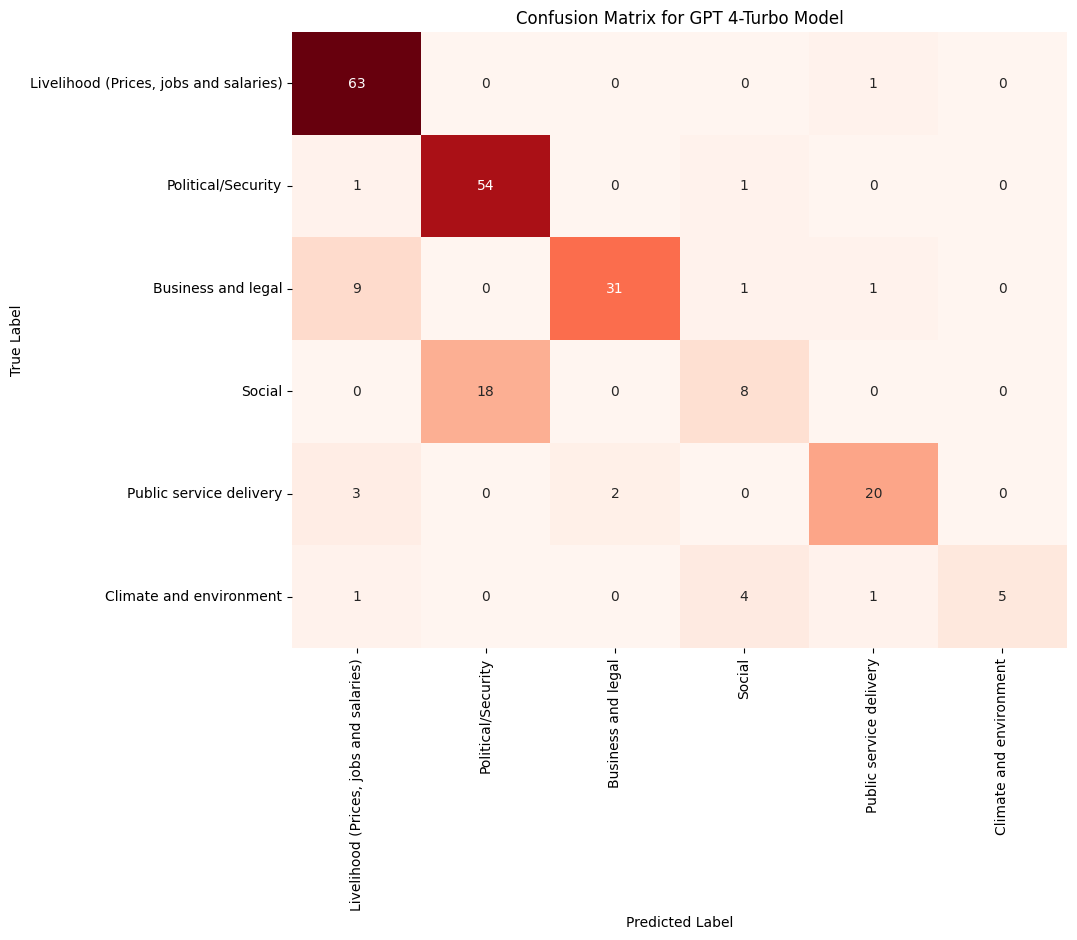

In [62]:
# Generate the confusion matrix
conf_matrix = confusion_matrix(df_gpt4_turbo['category'], df_gpt4_turbo['predicted_category'], labels=CATEGORIES)

# Plot the confusion matrix with a red color palette
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Reds", xticklabels=categories, yticklabels=categories, cbar=False)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for GPT 4-Turbo Model")
plt.show()

In [ ]:
# =======================================================
# EXAMINE MISCLASSIFIED INSTANCES FOR CATEGORY SOCIAL
# =======================================================
df_misclassified_social = df_gpt4_turbo[
    (df_gpt4_turbo['category'] == 'Social') & 
    (df_gpt4_turbo['predicted_category'] == 'Political/Security')
]

# Save misclassified examples 
df_misclassified.to_csv(DIR_DATA.joinpath("social-misclassified.csv"), index=False)

# df_misclassified = df_misclassified [['notes', 'description',
#        'category', 'predicted_category']]


## 3. Classify the Entire Dataset

In the previous section, we evaluated the performance of several state-of-the-art LLMs and smaller language models (e.g., BERT) to understand how well they could classify the `note` into our predetermined six categories. Among these models, OpenAI's `GPT-4-turbo` performed exceptionally well. Moving forward, we will use the `GPT-4-turbo` model to classify our entire target dataset, which includes the `note` and `description` columns providing detailed information about each protest. We will follow this process:

### Use Few-Shot Learning to Improve GPT-4-turbo Performance

In the earlier section, we assessed the performance of `GPT-4-turbo` and other models without providing them with any examples or additional training (zero-shot learning). In this scenario, `GPT-4-turbo` achieved an accuracy of 82%. However, the confusion matrix revealed significant variation in performance across categories. For instance, the precision for categories such as **social** was notably poor.

Now that we are classifying the entire dataset, we will leverage a technique called `few-shot learning`. This involves providing examples to the LLM and then asking it to classify data based on the patterns demonstrated in the examples. This approach almost always enhances the model’s performance.


### Check Performance of GPT-4-turbo with Few-Shot Learning

While we gained an initial understanding of how well `GPT-4-turbo` performed in the zero-shot classification scenario, it is important to quantify its performance when examples are provided. To achieve this, we will split our dataset of 212 training examples into a train set (e.g., 80% of the data) and a test set. We will then randomly select examples from the train set (e.g., 5, 10, 15 examples) to pass to the LLM and evaluate its performance. We will also revisit the confusion matrix to determine whether few-shot learning improves the model’s performance for categories such as **social**, which previously suffered from high misclassification rates.

### Classify the entire dataset
Once we determine the optimal number of examples to use, the most effective prompt strategy, and how well the few-shot example setting performs, we will apply the same prompt template, formatting, and settings to classify each protest. This will result in a new column, ```classification```, being added to the dataset. Given that there are approximately 25,000 protest instances, this process typically takes around 2–3 hours, depending on the number of examples provided.

### Perform Sanity Checks

The steps above will give us confidence in how well the LLM performs. For instance, if the LLM achieves 90% accuracy, we can reasonably expect that approximately 90% of the classifications for the entire dataset will be correct. Beyond this, there are additional sanity checks we can perform to further validate the model’s classifications:

- **Compare the distribution of model classifications with the training data (212 examples):**  
  While the distributions do not need to be identical, we expect them to be comparable. Significant discrepancies might indicate issues with the model's classifications.

- **Analyze the similarity of notes within a category versus across categories:**  
  Intuitively, protest descriptions within a category (e.g., **social**) should exhibit greater semantic similarity (measured using techniques like cosine similarity) compared to descriptions from different categories. We will perform this analysis to confirm whether this pattern holds true.

- **Verify classifications against real-world knowledge:**  
  As previously demonstrated, we can cross-check classifications against actual historical data. For instance, if the LLM classifies a large number of protests as **social** in January 2024 but there is no record of such a spike, it may indicate misclassification by the LLM.

### 3.1 Assessing Classification Accuracy with Few-Shot Examples
To evaluate `GPT-4-turbo` under few-shot learning, we will split our dataset of 212 training examples into a train set (e.g., 80%) and a test set. By providing varying numbers of examples (e.g., 5, 10, 15) from the train set, we aim to balance performance, running time, and cost while identifying the most effective prompting strategy. We will also revisit the confusion matrix to assess improvements in category-specific performance, such as **social**, which previously showed high misclassification rates.

In [9]:
def gpt4_turbo_classification(dataset, categories):
    predictions = []
    for note in dataset['notes']:
        # Format the prompt with the note and available categories
        prompt = prompt_template.format(categories=", ".join(categories), note=note)
        response = llm(prompt)
        predictions.append(response.strip())
    
    dataset['predicted_category'] = predictions
    
    # Calculate accuracy
    accuracy = accuracy_score(dataset['category'], dataset['predicted_category'])
    # Calculate macro precision and macro recall
    macro_precision = precision_score(dataset['category'], dataset['predicted_category'], average='macro')
    macro_recall = recall_score(dataset['category'], dataset['predicted_category'], average='macro')
    return accuracy, macro_precision, macro_recall

### 3.1.1 Split the examples into training and test
It’s important to note that this approach differs from the typical machine learning paradigm, where around 70-80% of the dataset is used for training and the remainder for evaluation. With LLMs like GPT-4-turbo, feeding too many examples slows down the process and significantly increases costs. 

To evaluate how well the LLM performs under few-shot learning, it’s more practical to allocate a larger portion of the data for testing and a smaller portion for providing examples to the model. Therefore, we split the dataset into 40% for training and 60% for testing.

Examples for the model will be drawn from the 40% training portion, and the model’s performance will be evaluated on the 60% test portion. This strategy ensures we can thoroughly evaluate the model while keeping costs and runtime manageable.


In [12]:
# ===========================================
# SPLIT THE EXAMPLES INTO TRAINING AND TEST
# ===========================================
# Split the data while maintaining the distribution of categories
train_df = df_prot.groupby('category', group_keys=False).apply(lambda x: x.sample(frac=PROP_TRAIN, 
random_state=42))
test_df = df_prot.drop(train_df.index)

(train_df.shape, test_df.shape)

/var/folders/k5/p4nvl2pj4gq2ks0j7qvrhwbh0000gp/T/ipykernel_49121/1674196748.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  train_df = df_prot.groupby('category', group_keys=False).apply(lambda x: x.sample(frac=PROP_TRAIN,


((112, 6), (112, 6))

In [13]:
pretty_print_value_counts(train_df, "category", 
title="Train-Distribution of Protest Classes", line_length=60)

           Train-Distribution of Protest Classes            


Category,Count,Percent,Cum. Percent
"Livelihood (Prices, jobs and salaries)",32,28.57%,28.57%
Political/Security,28,25.00%,53.57%
Business and legal,21,18.75%,72.32%
Social,13,11.61%,83.93%
Public service delivery,12,10.71%,94.64%
Climate and environment,6,5.36%,100.00%


In [14]:
pretty_print_value_counts(test_df, "category", 
title="Test-Distribution of Protest Classes", line_length=60)

            Test-Distribution of Protest Classes            


Category,Count,Percent,Cum. Percent
"Livelihood (Prices, jobs and salaries)",32,28.57%,28.57%
Political/Security,28,25.00%,53.57%
Business and legal,21,18.75%,72.32%
Social,13,11.61%,83.93%
Public service delivery,13,11.61%,95.54%
Climate and environment,5,4.46%,100.00%


### 3.1.2 . Prepare Examples 
For each example, we use three columns to provide information to the LLM: `notes`, `description`, and `category`. These columns must be formatted appropriately before being passed to the model.

We use a variable, `NUM_EXAMPLES`, to specify the number of examples per category to include. After experimenting with 5, 10, and 15 examples, we determined that 10 examples (which gives a total of 60 examples with 6 categories) strike the optimal balance. However, it’s important to note that some classes, such as `climate`, have only 11 examples available in the training dataset.


In [67]:
def generate_formatted_examples(train_df, num_examples):
    """
    Generates and formats examples from the training dataset for prompt construction.

    Parameters:
    - train_df (pd.DataFrame): The training dataset containing 'notes', 'description', and 'category' columns.
    - num_examples (int): Number of examples to use per category.

    Returns:
    - str: Formatted examples as a single string for use in a prompt.
    """
    examples = []

    # Select examples based on num_examples
    for category in CATEGORIES:
        # Get all samples if fewer than num_examples exist, otherwise take num_examples
        category_samples = train_df[train_df['category'] == category].sample(
            min(num_examples, len(train_df[train_df['category'] == category])), random_state=42
        )
        examples.extend(category_samples[['notes', 'description', 'category']].values.tolist())

    # Format the examples for the prompt
    formatted_examples = "\n".join(
        [
            f"Example {i+1}:\nNotes: {example[0]}\nDescription: {example[1]}\nCategory: {example[2]}"
            for i, example in enumerate(examples)
        ]
    )

    return formatted_examples


### 3.1.3 Prepare Prompt Template
Experimenting with multiple templates is essential because the way information is presented to an LLM can significantly impact its performance. In this case, the template must ensure the model pays attention to all three columns: `notes`, `description`, and `category`. Additionally, the template should be designed to instruct the LLM to output only the classification, as models sometimes prepend additional text before the category or classification, which can lead to inconsistent results. By refining the template, we can maximize accuracy and ensure the outputs are structured correctly for downstreaming data processing and usage of the data.

In [16]:
# =============================
# PREPARE TEMPLATE 
# =============================
classification_prompt_template = """
You are a highly intelligent assistant. Your task is to classify each document into one of the following categories:
- Political/Security
- Livelihood (Prices, jobs and salaries)
- Public service delivery
- Business and legal
- Climate and environment
- Social

Each category has a description that helps explain its purpose.

Here are some examples:

{examples}

Given the following document:
{document}

Based on the descriptions and the examples, which category does this document fall into? Please respond with one of the categories listed above.
Please respond with only the category name without adding other information.
"""

In [17]:
# Step 2: Initialize the LLM (OpenAI in this case)
llm = ChatOpenAI(model=OPENAI_MODEL)

# Step 5: Create a prompt template using Langchain
classification_prompt = PromptTemplate(
    input_variables=["document", "examples"],
    template=classification_prompt_template
)

# Step 6: Create a Langchain with the LLM and the classification prompt template
classification_chain = LLMChain(
    llm=llm,
    prompt=classification_prompt
)

/var/folders/k5/p4nvl2pj4gq2ks0j7qvrhwbh0000gp/T/ipykernel_49121/2134438236.py:11: LangChainDeprecationWarning: The class `LLMChain` was deprecated in LangChain 0.1.17 and will be removed in 1.0. Use :meth:`~RunnableSequence, e.g., `prompt | llm`` instead.
  classification_chain = LLMChain(


In [ ]:
# Test with all the 'notes' column from test_df
documents = test_df['notes'].tolist()

# Formatted examples
formatted_examples = generate_formatted_examples(train_df, num_examples=NUM_EXAMPLES)

# Classify each document and store results
classifications = []
for doc in documents:
    result = classification_chain.run(document=doc, examples=formatted_examples)
    # Clean up the result by removing the "Category: " prefix if it exists
    cleaned_result = result.strip().replace("Category: ", "")
    classifications.append(cleaned_result)  # Store the cleaned classification

# Add the cleaned classification results to the DataFrame as a new column
test_df['predicted_category'] = classifications

# Calculate accuracy
correct_predictions = (test_df['predicted_category'] == test_df['category']).sum()
total_predictions = len(test_df)
accuracy = correct_predictions / total_predictions

# Calculate macro-precision and macro-recall
macro_precision = precision_score(test_df['category'], test_df['predicted_category'], average='macro', zero_division=0)
macro_recall = recall_score(test_df['category'], test_df['predicted_category'], average='macro', zero_division=0)

# Print the results
print("="*62)
print(f" Accuracy and Other Metrics for: {OPENAI_MODEL} with {NUM_EXAMPLES} Examples")
print("="*62)
print(f" Accuracy: {accuracy * 100:.2f}%")
print(f" Macro-Precision: {macro_precision * 100:.2f}%")
print(f" Macro-Recall: {macro_recall * 100:.2f}%")
print("-"*62)


![GPT-4-turbo Perfomance with Few-shot Examples](../../docs/images/protest-classification/results-few-shot.png)


In [19]:
pretty_print_value_counts(test_df, "predicted_category", 
title="Distribution- Predicted Categories in Test Set", line_length=60)

       Distribution- Predicted Categories in Test Set       


Category,Count,Percent,Cum. Percent
"Livelihood (Prices, jobs and salaries)",31,27.68%,27.68%
Political/Security,26,23.21%,50.89%
Business and legal,26,23.21%,74.11%
Social,13,11.61%,85.71%
Public service delivery,11,9.82%,95.54%
Climate and environment,5,4.46%,100.00%


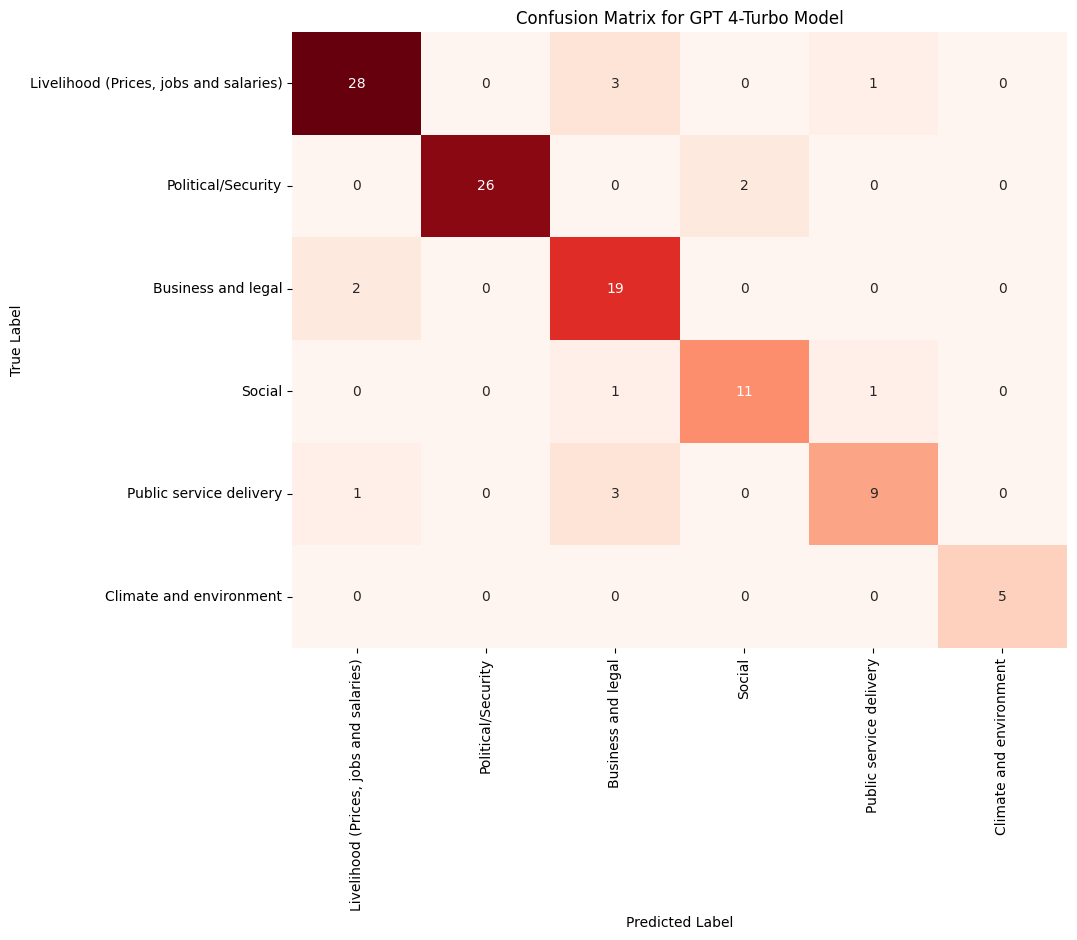

In [ ]:
# Generate the confusion matrix
conf_matrix = confusion_matrix(test_df['category'], test_df['predicted_category'], labels=CATEGORIES)

# Plot the confusion matrix with a red color palette
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Reds", xticklabels=categories, yticklabels=categories, cbar=False)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for GPT 4-Turbo Model")
plt.show()

###  3.2 Classify All Documents 
We are now ready to classify all the documents in the dataset using the previously defined prompt template and example formatting strategy. This approach has achieved approximately 90% accuracy and precision for 112 test examples, utilizing 10 examples per category for a total of 60 examples.

In [85]:
def classify_with_retry(document, examples, categories, max_retries=5):
    """
    Classifies the document, retrying if the initial classification is not in the specified categories.
    
    Parameters:
    - document (str): The document to classify.
    - examples (list): Examples to use for classification.
    - categories (list) : Categories to ensure classification is within required categories
    - max_retries (int): Number of retries allowed if classification is not in specified categories.

    Returns:
    - str: The final classification or 'Failed2Classify' if classification is unsuccessful.
    """
    for _ in range(max_retries + 1):
        result = classification_chain.run(document=document, examples=examples)
        cleaned_result = result.strip().replace("Category: ", "")
        
        if cleaned_result in categories:
            return cleaned_result  
    
    # If classification failed after retries, label as "Failed2Classify"
    return "Failed2Classify"

In [148]:
def classify_entire_dataset(df_train, df_target, output_file, categories, checkpoint_interval=100, sample=1):
    """
    Classifies a large dataset with the ability to resume from a checkpoint in case of interruptions.

    Parameters:
    - df_train (pd.DataFrame): DataFrame where we are drawing examples from.
    - df_target (pd.DataFrame): Inference dataset.
    - output_file (str): File path to save progress.
    - categories (list): Categories defining all classes.
    - checkpoint_interval (int): Number of rows to process before saving a checkpoint.
    - sample (float): Whether to run on everything or a sampled fraction.

    Returns:
    - pd.DataFrame: DataFrame with classifications added.
    """
    # Generate formatted examples
    examples = generate_formatted_examples(df_train, num_examples=NUM_EXAMPLES)
    
    # Load progress if output_file exists, merge with df_target
    try:
        df_classified = pd.read_csv(output_file)
        print(f"Loaded progress from {output_file}. Resuming classification.")
    except FileNotFoundError:
        df_classified = df_target.copy()
        df_classified['predicted_category'] = None

    # Whether to run on everything or sample
    num_rows = int(sample*df_classified.shape[0])
    print(f"WILL STOP AT {num_rows} ROWS FOR DEBUGGING PURPOSES")
    print("-"*40)

    # Ensure all rows are included by merging the progress
    if 'predicted_category' in df_classified.columns:
        df_classified = df_target.merge(
            df_classified[['notes', 'predicted_category']], on='notes', how='left', suffixes=('', '_classified')
        )
        df_classified['predicted_category'] = df_classified['predicted_category'].combine_first(df_classified.get('predicted_category_classified', pd.Series(None, index=df_classified.index)))
        if 'predicted_category_classified' in df_classified.columns:
            df_classified.drop(columns=['predicted_category_classified'], inplace=True)
    else:
        print("No progress file found or 'predicted_category' column missing; starting fresh.")

    # Classify unprocessed or failed rows
    count = 0
    for idx, row in tqdm(df_classified.iterrows(), total=len(df_classified)):
        if pd.isna(row['predicted_category']) or row['predicted_category'] == "Failed2Classify":
            try:
                classification = classify_with_retry(row['notes'], examples, CATEGORIES, max_retries=5)
                df_classified.at[idx, 'predicted_category'] = classification
            except Exception as e:
                print(f"Error at row {idx}: {e}")
                df_classified.at[idx, 'predicted_category'] = "Failed2Classify"

        # Save progress at intervals
        if idx % checkpoint_interval == 0:
            df_classified.to_csv(output_file, index=False)
            print(f"Checkpoint saved to {output_file} after {idx} rows.")
        
        # Stop once we hit num_rows as per sample size
        if count == num_rows:
            print("STOPPING EARLY FOR DEBUGGING")
            break
        count += 1

    # Save final results
    df_classified.to_csv(output_file, index=False)
    print(f"Classification completed. Results saved to {output_file}.")
    return df_classified


In [153]:
# ========================================
# LOAD THE DATA AND PERFOM CLASSIFICATION
# ========================================
df_all = pd.read_csv(FILE_PROTESTS)
df_all.drop(columns=["Unnamed: 0"], inplace=True)
csv_output = DIR_DATA.joinpath("protests-labeled-all-gpt4-turbo.csv")
df_prot_classified = classify_entire_dataset(df_prot, df_all, csv_output, categories, 
checkpoint_interval=100, sample=0.05)


Loaded progress from /Users/dunstanmatekenya/Library/CloudStorage/OneDrive-WBG(2)/Data-Lab/iran-economic-monitoring/data/conflict/protests-labeled-all-gpt4-turbo.csv. Resuming classification.
WILL STOP AT 1294 ROWS FOR DEBUGGING PURPOSES
----------------------------------------


  0%|          | 1/31527 [00:00<1:33:52,  5.60it/s]

Checkpoint saved to /Users/dunstanmatekenya/Library/CloudStorage/OneDrive-WBG(2)/Data-Lab/iran-economic-monitoring/data/conflict/protests-labeled-all-gpt4-turbo.csv after 0 rows.


  0%|          | 101/31527 [00:00<01:32, 338.93it/s]

Checkpoint saved to /Users/dunstanmatekenya/Library/CloudStorage/OneDrive-WBG(2)/Data-Lab/iran-economic-monitoring/data/conflict/protests-labeled-all-gpt4-turbo.csv after 100 rows.


  1%|          | 201/31527 [00:00<01:11, 440.13it/s]

Checkpoint saved to /Users/dunstanmatekenya/Library/CloudStorage/OneDrive-WBG(2)/Data-Lab/iran-economic-monitoring/data/conflict/protests-labeled-all-gpt4-turbo.csv after 200 rows.


  1%|          | 301/31527 [00:00<01:02, 496.42it/s]

Checkpoint saved to /Users/dunstanmatekenya/Library/CloudStorage/OneDrive-WBG(2)/Data-Lab/iran-economic-monitoring/data/conflict/protests-labeled-all-gpt4-turbo.csv after 300 rows.


  1%|▏         | 401/31527 [00:00<00:59, 525.71it/s]

Checkpoint saved to /Users/dunstanmatekenya/Library/CloudStorage/OneDrive-WBG(2)/Data-Lab/iran-economic-monitoring/data/conflict/protests-labeled-all-gpt4-turbo.csv after 400 rows.


  2%|▏         | 501/31527 [00:01<00:58, 534.69it/s]

Checkpoint saved to /Users/dunstanmatekenya/Library/CloudStorage/OneDrive-WBG(2)/Data-Lab/iran-economic-monitoring/data/conflict/protests-labeled-all-gpt4-turbo.csv after 500 rows.


  2%|▏         | 601/31527 [00:01<00:56, 552.06it/s]

Checkpoint saved to /Users/dunstanmatekenya/Library/CloudStorage/OneDrive-WBG(2)/Data-Lab/iran-economic-monitoring/data/conflict/protests-labeled-all-gpt4-turbo.csv after 600 rows.


  2%|▏         | 701/31527 [01:22<5:21:45,  1.60it/s]

Checkpoint saved to /Users/dunstanmatekenya/Library/CloudStorage/OneDrive-WBG(2)/Data-Lab/iran-economic-monitoring/data/conflict/protests-labeled-all-gpt4-turbo.csv after 700 rows.


  3%|▎         | 801/31527 [02:59<8:53:28,  1.04s/it] 

Checkpoint saved to /Users/dunstanmatekenya/Library/CloudStorage/OneDrive-WBG(2)/Data-Lab/iran-economic-monitoring/data/conflict/protests-labeled-all-gpt4-turbo.csv after 800 rows.


  3%|▎         | 901/31527 [04:47<11:37:24,  1.37s/it]

Checkpoint saved to /Users/dunstanmatekenya/Library/CloudStorage/OneDrive-WBG(2)/Data-Lab/iran-economic-monitoring/data/conflict/protests-labeled-all-gpt4-turbo.csv after 900 rows.


  3%|▎         | 1001/31527 [06:51<11:13:32,  1.32s/it]

Checkpoint saved to /Users/dunstanmatekenya/Library/CloudStorage/OneDrive-WBG(2)/Data-Lab/iran-economic-monitoring/data/conflict/protests-labeled-all-gpt4-turbo.csv after 1000 rows.


  3%|▎         | 1101/31527 [08:55<10:35:15,  1.25s/it]

Checkpoint saved to /Users/dunstanmatekenya/Library/CloudStorage/OneDrive-WBG(2)/Data-Lab/iran-economic-monitoring/data/conflict/protests-labeled-all-gpt4-turbo.csv after 1100 rows.


  4%|▍         | 1201/31527 [10:59<10:43:13,  1.27s/it]

Checkpoint saved to /Users/dunstanmatekenya/Library/CloudStorage/OneDrive-WBG(2)/Data-Lab/iran-economic-monitoring/data/conflict/protests-labeled-all-gpt4-turbo.csv after 1200 rows.


  4%|▍         | 1294/31527 [12:56<5:02:15,  1.67it/s] 

STOPPING EARLY FOR DEBUGGING
Classification completed. Results saved to /Users/dunstanmatekenya/Library/CloudStorage/OneDrive-WBG(2)/Data-Lab/iran-economic-monitoring/data/conflict/protests-labeled-all-gpt4-turbo.csv.


### 3.3 Conduct Quality Assurance on Classified Protests
Now that we have used the LLM to add a category, in the column names ```predicted_category``` for all protests instances in our dataset. We will perfom some sanity checks to make sure that the predicted categories actually make sense.


In [155]:
df_prot_pred = pd.read_csv(DIR_DATA.joinpath("protests-labeled-all-gpt35-turbo.csv"))

#### 3.3.1 Compare Distributions
In the training dataset, we check distribution (frequency distribution) for the variable ```category``` and compare it with frequency distribution for ```predicted_category```- categories generated by LLM. Although we dont expect axact match, we expect these distributions to be comparable. 

In [170]:
predicted_cnts = df_prot_pred.classification.value_counts(normalize=True)*100
actual_cnts = df_prot.category.value_counts(normalize=True)*100

In [171]:
all_labels = sorted(set(df_prot_pred.classification.unique()))
predicted_cnts = predicted_cnts.reindex(all_labels, fill_value=0)
actual_cnts = actual_cnts.reindex(all_labels, fill_value=0)

df_comparison = pd.DataFrame({'predicated_category': predicted_cnts,
'actual_cnts': actual_cnts})

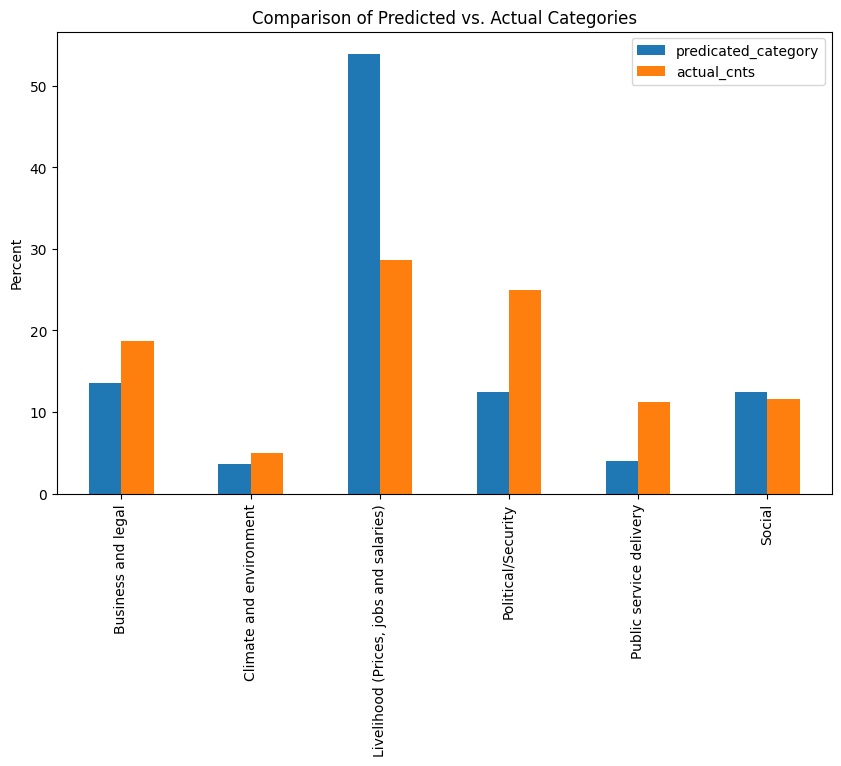

In [173]:
df_comparison.plot(kind='bar', figsize=(10,6))
plt.title("Comparison of Predicted vs. Actual Categories")
plt.ylabel("Percent")
plt.show()

In [157]:
pretty_print_value_counts(df_prot_pred, "classification", 
"Distribution of Predicted Categories",line_length=60 )

            Distribution of Predicted Categories            


Category,Count,Percent,Cum. Percent
"Livelihood (Prices, jobs and salaries)","13,459",53.93%,53.93%
Business and legal,"3,369",13.50%,67.43%
Social,"3,119",12.50%,79.93%
Political/Security,"3,109",12.46%,92.39%
Public service delivery,984,3.94%,96.33%
Climate and environment,915,3.67%,100.00%


In [174]:
pretty_print_value_counts(df_prot, "category", 
"Distribution of Actual Categories in Training Data",line_length=60 )

     Distribution of Actual Categories in Training Data     


Category,Count,Percent,Cum. Percent
"Livelihood (Prices, jobs and salaries)",64,28.57%,28.57%
Political/Security,56,25.00%,53.57%
Business and legal,42,18.75%,72.32%
Social,26,11.61%,83.93%
Public service delivery,25,11.16%,95.09%
Climate and environment,11,4.91%,100.00%


#### 3.3.2 Similarity of notes within and across categories
In order to have confidence about the classifications generated by the model, 
lets perform some sanity checks. 

In [84]:
def calculate_cosine_similarity_matrix(df, categories):
    """
    Calculate a cosine similarity matrix for all categories by comparing embeddings within and across categories.

    Parameters:
    - df: DataFrame containing the 'notes' embeddings and 'predicted_category'.
    - categories: List of unique categories to compare.

    Returns:
    - similarity_matrix (pd.DataFrame): A DataFrame representing the cosine similarity matrix.
    """
    # Initialize an empty matrix for similarity scores
    similarity_matrix = np.zeros((len(categories), len(categories)))

    # Calculate cosine similarities within and across categories
    for i, category1 in enumerate(categories):
        # Filter embeddings for category1
        embeddings_category1 = np.vstack(df[df['predicted_category'] == category1]['embedding'].values)

        for j, category2 in enumerate(categories):
            # Filter embeddings for category2
            embeddings_category2 = np.vstack(df[df['predicted_category'] == category2]['embedding'].values)

            # Calculate cosine similarities between embeddings in category1 and category2
            similarity_scores = cosine_similarity(embeddings_category1, embeddings_category2).flatten()
            avg_similarity = np.mean(similarity_scores) if len(similarity_scores) > 0 else 0
            similarity_matrix[i, j] = avg_similarity

    # Convert the matrix to a DataFrame for readability
    similarity_df = pd.DataFrame(similarity_matrix, index=categories, columns=categories)
    return similarity_df

In [98]:
def calculate_distance_matrix(df, categories, distance_metric="euclidean"):
    """
    Calculate a distance matrix for all categories by comparing embeddings within and across categories.

    Parameters:
    - df: DataFrame containing the 'notes' embeddings and 'predicted_category'.
    - categories: List of unique categories to compare.
    - distance_metric: Type of distance to compute (e.g., 'euclidean', 'manhattan').

    Returns:
    - distance_matrix (pd.DataFrame): A DataFrame representing the distance matrix.
    """
    # Initialize an empty matrix for distance scores
    distance_matrix = np.zeros((len(categories), len(categories)))

    # Calculate distances within and across categories
    for i, category1 in enumerate(categories):
        # Filter embeddings for category1
        embeddings_category1 = np.vstack(df[df['predicted_category'] == category1]['embedding'].values)

        for j, category2 in enumerate(categories):
            # Filter embeddings for category2
            embeddings_category2 = np.vstack(df[df['predicted_category'] == category2]['embedding'].values)

            # Calculate pairwise distances between embeddings in category1 and category2
            distance_scores = cdist(embeddings_category1, embeddings_category2, metric=distance_metric).flatten()
            avg_distance = np.mean(distance_scores) if len(distance_scores) > 0 else 0
            distance_matrix[i, j] = avg_distance

    # Convert the matrix to a DataFrame for readability
    distance_df = pd.DataFrame(distance_matrix, index=categories, columns=categories)
    return distance_df

In [94]:
# Load dataset
df_classified_protests = pd.read_csv(DIR_DATA.joinpath("protests-labeled-all-gpt.csv"))
categories = list(df_classified_protests.classification.unique())
df_classified_protests.rename(columns={"classification":"predicted_category"}, inplace=True)

In [95]:
# =========================================
# LOAD AND CREATE EMBEDDINGS FOR DATAFRAME
# =========================================
# Initialize OpenAI embeddings
embedding_model = OpenAIEmbeddings(model="text-embedding-ada-002", 
openai_api_type=OPENAI_API_KEY)

# Embed each note and store the embeddings in the DataFrame
df_classified_protests['embedding'] = embedding_model.embed_documents(df_classified_protests['notes'].tolist())

In [96]:
# =========================================
# SKLEARN COSINE SIMILARITY
# =========================================
cosine_similarity_matrix = calculate_cosine_similarity_matrix(df_classified_protests, categories)

print("="*60)
print(" Cosine Similarity Matrix (Within and Across Categories)")
print("="*60)
display(cosine_similarity_matrix)
print("-"*60)


 Cosine Similarity Matrix (Within and Across Categories)


,Political/Security,"Livelihood (Prices, jobs and salaries)",Climate and environment,Business and legal,Social,Public service delivery
Political/Security,0.859897,0.824101,0.832180,0.827453,0.842172,0.831968
"Livelihood (Prices, jobs and salaries)",0.824101,0.862665,0.835149,0.847127,0.836176,0.838875
Climate and environment,0.832180,0.835149,0.871537,0.835849,0.833948,0.853963
Business and legal,0.827453,0.847127,0.835849,0.854858,0.835603,0.838907
Social,0.842172,0.836176,0.833948,0.835603,0.856032,0.837756
Public service delivery,0.831968,0.838875,0.853963,0.838907,0.837756,0.855566


------------------------------------------------------------


In [100]:
# =========================================
# SKLEARN COSINE SIMILARITY
# =========================================
euclidean_similarity_matrix = calculate_distance_matrix(df_classified_protests, categories)

print("="*60)
print(" Euclidean Distance Similarity Matrix (Within and Across Categories)")
print("="*60)
display(euclidean_similarity_matrix)
print("-"*60)

 Euclidean Distance Similarity Matrix (Within and Across Categories)


,Political/Security,"Livelihood (Prices, jobs and salaries)",Climate and environment,Business and legal,Social,Public service delivery
Political/Security,0.524813,0.592096,0.578313,0.586535,0.560115,0.578551
"Livelihood (Prices, jobs and salaries)",0.592096,0.520636,0.573156,0.550857,0.570876,0.566408
Climate and environment,0.578313,0.573156,0.502413,0.572053,0.575235,0.538168
Business and legal,0.586535,0.550857,0.572053,0.534887,0.572438,0.566481
Social,0.560115,0.570876,0.575235,0.572438,0.532147,0.568317
Public service delivery,0.578551,0.566408,0.538168,0.566481,0.568317,0.534158


------------------------------------------------------------


## 4. Limitations and Challenges
There are two main limitations organized in two categories as below:
### Cost related challenges
It is expensive to run OpenAI models when you have many tokens. The main drivers of the cost when using commercial LLMs in general are provide below.
- **Need to use best performing model**. In order to get good performance without investing in further model fine-tuning, we need to use commercial models such as that from OpenAI which we used. Furthermore, from OpenAI, best performing models are the latest models which are expensive.
- **Large number of examples**.Again here, we need to pass more examples to the model in order to get better performance because generally speaking, this enables the model to learn from the examples. However, more examples means we are passing more tokens to OpenAI API which drives the cost up as the charging is done per token. 
- **Large dataset** We need to generate the classifications on a dataset size of 24k rows. This isnt by any stretch of imagination a large dataset, however for tasks involing LLMs where you are paying by tokens, this again drives the cost up as each ```note``` contains many tokens.
- **Price for experimentation**. In order to determine optimal parameters and other things
### Compute resource and processing time
Although compute resources can be accessed with budget availability, LLMs generally take long to run due to the large number of parameters. In order to experiment fast, get results faster and be cost effective, sometimes you sacfrice a little bit of perfomance gains. 

### Classification results are not 100% accurate
In most cases, acheiving 90% classification accuracy is good enough.Ultimately, what number counts as accurate enough varies depending on use case. In this case, we still have to live with the fact that potentially 5-10% of the classifications are wrong and there is no way to know which one. Howeever, again the sanity checks we conducted do provide a recourse to increase confidence in the results of the LLM.



## 5. Potential Next Steps
### Further sanity checks
In a separate notebooks, more analysis will be done particulary focusing on time to check and demonstrate that what we got from the LLM is reasonable and matches what was happening on ground.

### Further tuning of the model
As mentioned above, the experimentation in this work was limited by available resources. Its possible to squeeze out more perfomance by utilizing a more performant OpenAI model (e.g., ```gpt-4o```). Secondly, more experiments could be done to check to see if increasing number of examples further would improve results or whether selecting examples in a smarter way (e.g., semantic selection) which would select examples based on similary to the target ```note``` in question would yield better results. Finally, we also could try several prompting strategies to see if that also gives better perfomance. 


## 6. References
